In [1]:
import os, sys, pickle
import numpy as np
import pandas as pd
import json
import argparse
import hyperopt

import product_fem as pf
import fenics
import inference

In [2]:
params = {
    "method": "BFGS",
    "options": {
        'gtol': 1e-8,
        'xrtol': 1e-8,
        'maxiter': 50,
    },
    "boundary": {"epsilon": 0.03, "eps0": 0.05, "eps1": 0.1},
    "min_xy": 0.2,
    "max_xy": 0.8,
    "spatial_data": "simulation/bias_saddle/out_123456_stats/rep921586.stats.csv",
    "genetic_data": "simulation/bias_saddle/out_123456_stats/rep921586.pairstats.csv",
    "mesh": {"x": [0, 30], "y": [0, 20], "n": 5},
    "regularization": {"l2": [0.01, 0.01], "smoothing": [0.1, 0.1]},
}

In [3]:
spatial_data = pd.read_csv(params["spatial_data"])
genetic_data = pd.read_csv(params['genetic_data'])
data = inference.SpatialDivergenceData(spatial_data, genetic_data)
data.normalise(min_xy=params["min_xy"], max_xy=params["max_xy"])

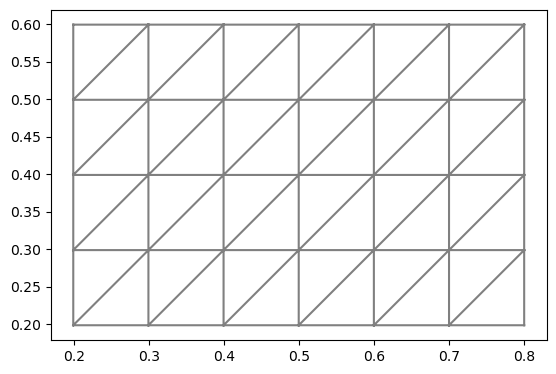

In [4]:
mesh = data.mesh(**params['mesh'])
V = fenics.FunctionSpace(mesh, 'CG', 1)
W = pf.ProductFunctionSpace(V)
fenics.plot(mesh);

In [5]:
bdry = data.boundary_fn(eps0=params['boundary']['eps0'], eps1=params['boundary']['eps1'])
boundary = pf.transforms.callable_to_ProductFunction(bdry, W)

In [6]:
eqn = pf.HittingTimes(W, boundary, epsilon=params['boundary']['epsilon'])

xy0, xy1 = data.pair_xy()
sd = pf.SpatialData(
        data.genetic_data["divergence"].to_numpy(),
        xy0, xy1,
        W,
)

In [7]:
loss = pf.LossFunctional(sd, eqn.control, params['regularization'])
invp = pf.InverseProblem(eqn, loss)

In [8]:
m_hats, losses, optim_return = invp.optimize(
        eqn.control, 
        method=params['method'],
        options= #params['options'],
        { "gtol": 1e-6, "xrtol": 1e-6, "maxiter": 50 },
)

loss error l2reg smoothing
0.3220384552074036 0.3189911951274021 0.0010834512258857778 0.0019638088541157595
0.2185699143008376 0.1997916945090791 0.0009219964982722805 0.017856223293486205
0.17028170486273214 0.1268494031055983 0.0007749737998794726 0.042657327957254354
0.1535640586419248 0.09676454511285737 0.0006830135986848055 0.056116499930382625
0.1391251453991756 0.07454425630249512 0.0005844571389291897 0.06399643195775127
0.12309447540982899 0.056694158458589494 0.00047065984732127126 0.06592965710391822
0.10631741293947394 0.04371903621351888 0.00035631176447726616 0.06224206496147781
0.091534068430008 0.03638544002653099 0.0002694236290103224 0.05487920477446669
0.07860667490941534 0.0331920764232619 0.00021194631113114374 0.045202652175022284
0.06768639471289448 0.03269360859609315 0.0001780997180119213 0.0348146863987894
0.058544823427955854 0.03259127047942522 0.00015806512737217098 0.02579548782115846
0.04907708825206638 0.030166329288577935 0.00014032980621978258 0.0187

In [9]:
optim_return

  message: Maximum number of iterations has been exceeded.
  success: False
   status: 1
      fun: 0.00264007048087445
        x: [-1.068e-03  6.619e-03 ...  4.695e-01 -5.704e-01]
      nit: 50
      jac: [ 2.343e-05 -8.246e-06 ... -7.365e-05  1.266e-05]
 hess_inv: [[ 3.711e+00  3.905e-01 ... -2.713e+00  1.750e+00]
            [ 3.905e-01  2.470e+00 ... -1.836e+00 -5.952e-01]
            ...
            [-2.713e+00 -1.836e+00 ...  1.338e+01 -4.480e-01]
            [ 1.750e+00 -5.952e-01 ... -4.480e-01  5.092e+00]]
     nfev: 51
     njev: 51